# (실습) 케라스와 텐서플로우

## 텐서플로우 활용

순수 텐서플로우 API만을 이용하여 두 개의 층을 갖는 선형 분류 신경망을 구현한다.

In [ ]:
import tensorflow as tf
import numpy as np

**데이터셋 생성**

- `np.random.multivariate_normal()`
    - 다변량 정규분포를 따르는 데이터 생성
    - 평균값과 공분산 지정 필요
- 음성 데이터셋
    - 샘플 수: 1,000
    - 평균값: `[0, 3]`
    - 공분산: `[[1, 0.5],[0.5, 1]]`
- 양성 데이터셋
    - 샘플 수: 1,000
    - 평균값: `[3, 0]`
    - 공분산: `[[1, 0.5],[0.5, 1]]`

In [ ]:
num_samples_per_class = 1000

# 음성 데이터셋
negative_samples = np.random.multivariate_normal(
    mean=[0, 3], cov=[[1, 0.5],[0.5, 1]], size=num_samples_per_class)

# 양성 데이터셋
positive_samples = np.random.multivariate_normal(
    mean=[3, 0], cov=[[1, 0.5],[0.5, 1]], size=num_samples_per_class)

두 개의 `(1000, 2)` 모양의 양성, 음성 데이터셋을 하나의 `(2000, 2)` 모양의 데이터셋으로 합치면서
동시에 자료형을 `np.float32`로 지정한다.
자료형을 지정하지 않으면 `np.float64`로 지정되어 보다 많은 메모리와 실행시간을 요구한다.

In [ ]:
inputs = np.vstack((negative_samples, positive_samples)).astype(np.float32)

음성 샘플의 타깃은 0, 양성 샘플의 타깃은 1로 지정한다.

In [ ]:
targets = np.vstack((np.zeros((num_samples_per_class, 1), dtype="float32"),
                     np.ones((num_samples_per_class, 1), dtype="float32")))

양성, 음성 샘플을 색깔로 구분하면 다음과 같다.

- `inputs[:, 0]`: x 좌표
- `inputs[:, 1]`: x 좌표
- `c=targets[:, 0]`: 0 또는 1에 따른 색상 지정

In [ ]:
inputs.shape

(2000, 2)

In [ ]:
print(inputs[0])
print(inputs[0][1])

[1.0471996 2.547138 ]
2.547138


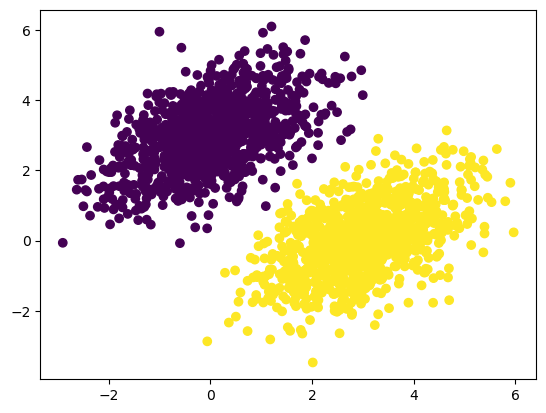

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(inputs[:, 0], inputs[:, 1], c=targets[:, 0])
plt.show()

**모델 지정**

아래 `dense()` 함수는 밀집층(dense layer)에서의 아핀 변환을 담당한다.

In [ ]:
def dense(inputs, W, b, activation=None):
    outputs = tf.matmul(inputs, W) + b
    if activation != None:
        return activation(outputs)
    else:
        return outputs

두 개의 밀집층(dense layer)으로 구성된 순차 모델을 선언한다.

- 첫째 층: 유닛 5개
- 둘째 층: 유닛 1개

층을 구현하기 위해 먼저 각 층에 사용될 가중치 행렬과 편향 벡터를 초기화 한다.

- 첫째층의 가중치 행렬과 편향 벡터
    - 가중치 행렬: (2, 5) 모양의 텐서
    - 편향 벡터: (5,) 모양의 텐서

In [ ]:
input_dim1 = 2    # 입력 샘플의 특성수 2개
output_dim1 = 5   # 첫째층의 유닛수 5개

# 가중치: 균등분포를 이용한 무작위 초기화
W1 = tf.Variable(initial_value=tf.random.uniform(shape=(input_dim1, output_dim1)))

# 편향: 0으로 초기화
b1 = tf.Variable(initial_value=tf.zeros(shape=(output_dim1,)))

- 둘째층의 가중치 행렬과 편향 벡터
    - 가중치 행렬: (5, 1) 모양의 텐서
    - 편향 벡터: (1,) 모양의 텐서

In [ ]:
input_dim2 = 5    # 입력 샘플의 특성수 5개. 첫째층의 유닛수와 동일.
output_dim2 = 1   # 하나의 값 출력

# 가중치: 무작위 초기화
W2 = tf.Variable(initial_value=tf.random.uniform(shape=(input_dim2, output_dim2)))

# 편향: 0으로 초기화
b2 = tf.Variable(initial_value=tf.zeros(shape=(output_dim2,)))

이제 모델을 선언할 수 있다.

In [ ]:
def model(inputs):
    outputs = dense(inputs, W1, b1, tf.nn.relu) # 첫째 층 아핀 변환. relu 활성화 함수 사용
    outputs = dense(outputs, W2, b2)    # 둘째 층 아핀 변환
    return outputs

**손실 함수 선언**

손실값은 타깃과 예측값 사이의 오차의 제곱의 평균값으로 한다.

In [ ]:
def square_loss(targets, predictions):
    per_sample_losses = tf.square(targets - predictions)
    return tf.reduce_mean(per_sample_losses)

**훈련 스텝**

하나의 배치에 대해 예측값을 계산한 후에 손실 함수의 그레이디언트를 이용하여 가중치와 편향을 업데이트한다.
배치를 전체 데이터셋으로 지정하기에 하나의 스텝은 하나의 에포크에 해당한다.

In [ ]:
learning_rate = 0.1

def training_step(inputs, targets):

    with tf.GradientTape() as tape:
        predictions = model(inputs)
        loss = square_loss(predictions, targets)

    grad_loss_wrt_W1, grad_loss_wrt_b1, grad_loss_wrt_W2, grad_loss_wrt_b2 = tape.gradient(loss, [W1, b1, W2, b2])

    W1.assign_sub(grad_loss_wrt_W1 * learning_rate)
    b1.assign_sub(grad_loss_wrt_b1 * learning_rate)
    W2.assign_sub(grad_loss_wrt_W2 * learning_rate)
    b2.assign_sub(grad_loss_wrt_b2 * learning_rate)

    return loss

**훈련 실행**

총 100번의 에포크를 실행한다.
10번의 에포크마다 손실값을 출력하도록 하였다.

In [ ]:
for step in range(100):
    loss = training_step(inputs, targets)
    if step % 10 == 0:
        print(f"Loss at step {step}: {loss:.4f}")

Loss at step 0: 21.5550
Loss at step 10: 0.3115
Loss at step 20: 0.2789
Loss at step 30: 0.2642
Loss at step 40: 0.2513
Loss at step 50: 0.2138
Loss at step 60: 0.1009
Loss at step 70: 0.0546
Loss at step 80: 0.0425
Loss at step 90: 0.0382


손실값이 계속해서 줄어들고 있기에 훈련을 더 하는 게 좋다.
아래 코드는 1000번 더 반복 훈련한다.
가중치와 편향이 초기화되지 않고 이어서 업데이트됨에 주의한다.
손실값은 대신 100번 훈련할 때마다 출력되도록 하였다.

In [ ]:
for step in range(1001):
    loss = training_step(inputs, targets)
    if step % 100 == 0:
        print(f"Loss at step {step}: {loss:.4f}")

Loss at step 0: 0.0360
Loss at step 100: 0.0273
Loss at step 200: 0.0223
Loss at step 300: 0.0196
Loss at step 400: 0.0189
Loss at step 500: 0.0187
Loss at step 600: 0.0187
Loss at step 700: 0.0187
Loss at step 800: 0.0187
Loss at step 900: 0.0187
Loss at step 1000: 0.0186


## 예측

In [ ]:
predictions = model(inputs)

예측 결과를 확인하면 다음과 같다.
예측값이 0.5보다 클 때 양성으로 판정한다.

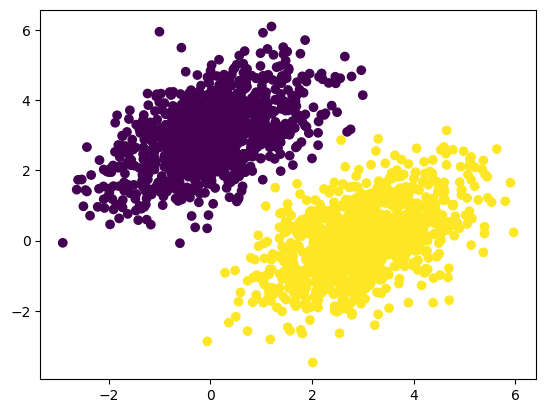

In [ ]:
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)
plt.show()

**문제 1**

위 코드는 학습과정에서 전체 데이터셋을 하나의 배치로 사용한다.
배치 크기를 예를 들어 16, 32, 64, 128 등으로 지정하여
에포크가 여러 개의 스텝으로 구성되도록 코드를 수정한 후에 훈련을 진행하여 최선의 모델을 구현하라.

견본 답안:

여기서는 배치 크기를 64를 이용한 훈련만 보여준다.
아래 코드를 참고하여 다른 경우를 실험하고 비교할 수 있다.

단계 1: 층과 유닛의 개수와 맞게 가중치 행렬과 편향 벡터를 초기화한다.

In [ ]:
tf.random.set_seed(1000)

# 첫째층: 유닛 5개
W1 = tf.Variable(initial_value=tf.random.uniform(shape=(2, 5)))
b1 = tf.Variable(initial_value=tf.zeros(shape=(5,)))

# 둘째층: 유닛 1개
W2 = tf.Variable(initial_value=tf.random.uniform(shape=(5, 1)))
b2 = tf.Variable(initial_value=tf.zeros(shape=(1,)))

단계 2: 밀집층을 이용하여 모델을 구성한다.

In [ ]:
def model(inputs):
    outputs = dense(inputs, W1, b1, tf.nn.relu) # 첫째 층 아핀 변환. relu 활성화 함수 사용
    outputs = dense(outputs, W2, b2)    # 둘째 층 아핀 변환
    return outputs

단계 3: 손실 함수를 정의한다.

In [ ]:
def square_loss(targets, predictions):
    per_sample_losses = tf.square(targets - predictions)
    return tf.reduce_mean(per_sample_losses)

단계 4: 훈련 스텝을 정의한다.
훈련 스텝은 입력 배치 단위로 예측값을 계산하는 포워드 패스와
계산된 손실값을 이용하여 층별 가중치 행렬과 편향 벡터를 업데이트하는 역전파로 구성된다.
학습률은 경사하강법을 적용할 때 필요하다.

In [ ]:
# 학습률
learning_rate = 0.01

def training_step(inputs, targets):

    with tf.GradientTape() as tape:
        predictions = model(inputs)
        loss = square_loss(predictions, targets)

    grad_loss_wrt_W1, grad_loss_wrt_b1, grad_loss_wrt_W2, grad_loss_wrt_b2 = tape.gradient(loss, [W1, b1, W2, b2])

    W1.assign_sub(grad_loss_wrt_W1 * learning_rate)
    b1.assign_sub(grad_loss_wrt_b1 * learning_rate)
    W2.assign_sub(grad_loss_wrt_W2 * learning_rate)
    b2.assign_sub(grad_loss_wrt_b2 * learning_rate)

    return loss

단계 5: 배치 단위로 모델을 훈련시킨다.
여기서는 배치 크기를 64로 지정한다.

In [ ]:
# 배치 크기
batch_size = 64

# 에포크 수
num_epoch = 100

for epoch in range(num_epoch+1):

    step_losses = [] # 스텝 단위의 손실값 저장

    # 배치 단위 훈련
    for step_S in range(0, inputs.shape[0], batch_size):

        # 배치 지정
        if step_S + batch_size < inputs.shape[0]:
            step_F = step_S + batch_size
        else:
            step_F = inputs.shape[0]

        # 손실값 계산 및 저장
        loss = training_step(inputs[step_S: step_F, :], targets[step_S : step_F, :])
        step_losses.append(loss)

    if epoch % 10 == 0: # 10 에포크마다 손실값 평균 출력
        epoch_loss = np.mean(step_losses)
        print(f"Loss at step {epoch}: {epoch_loss:.4f}")

Loss at step 0: 1.7268
Loss at step 10: 0.0343
Loss at step 20: 0.0298
Loss at step 30: 0.0278
Loss at step 40: 0.0265
Loss at step 50: 0.0254
Loss at step 60: 0.0245
Loss at step 70: 0.0236
Loss at step 80: 0.0228
Loss at step 90: 0.0221
Loss at step 100: 0.0213


전체 훈련셋을 대상으로 예측 결과를 시각적으로 확인한다.

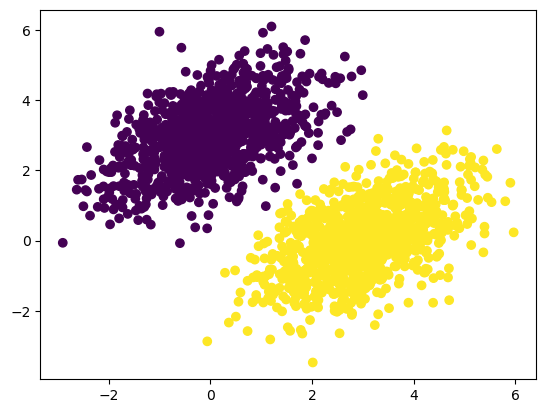

In [ ]:
# 예측 결과 확인
predictions = model(inputs)
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)
plt.show()

**문제 2**

예측 정확도(accuracy)를 평가지표(`metrics`)로 지정하여 훈련 에포크마다 손실값과 함께 출력하는 기능을 추가하라.
단, 예측값이 0.5 이상이면 양성, 아니면 음성으로 판정하며,
에포크의 손실값과 정확도는 스텝별로 계산된 손실값과 정확도의 평균값을 사용한다.

견본 답안:

이전 문제의 단계 4에서 에포크별 평균 정확도를 계산하는 기능만 추가하면 된다.
다만, 훈련을 처음부터 다시 시작하게 하려면 가중치와 편향을 초기화 해야 한다.

In [ ]:
tf.random.set_seed(1000)

# 첫째층: 유닛 5개
W1 = tf.Variable(initial_value=tf.random.uniform(shape=(2, 5)))
b1 = tf.Variable(initial_value=tf.zeros(shape=(5,)))

# 둘째층: 유닛 1개
W2 = tf.Variable(initial_value=tf.random.uniform(shape=(5, 1)))
b2 = tf.Variable(initial_value=tf.zeros(shape=(1,)))

단계 4: 훈련 스텝에 정확도 계산 기능 추가

In [ ]:
# 학습률
learning_rate = 0.01

def training_step(inputs, targets):

    with tf.GradientTape() as tape:
        predictions = model(inputs)
        loss = square_loss(predictions, targets)

    grad_loss_wrt_W1, grad_loss_wrt_b1, grad_loss_wrt_W2, grad_loss_wrt_b2 = tape.gradient(loss, [W1, b1, W2, b2])
    # 정확도 계산
    accuracy = ((predictions.numpy().round() == targets).sum()) / len(inputs)

    W1.assign_sub(grad_loss_wrt_W1 * learning_rate)
    b1.assign_sub(grad_loss_wrt_b1 * learning_rate)
    W2.assign_sub(grad_loss_wrt_W2 * learning_rate)
    b2.assign_sub(grad_loss_wrt_b2 * learning_rate)

    return loss, accuracy

단계 5 수정: 정확도 활용 기능 추가

In [ ]:
batch_size = 64

num_epoch = 100

for epoch in range(num_epoch+1):

    step_losses = []
    step_accuracies = []

    for step_S in range(0, inputs.shape[0], batch_size):

        if step_S + batch_size < inputs.shape[0]:
            step_F = step_S + batch_size
        else:
            step_F = inputs.shape[0]

        # 정확도 활용 추가
        loss, accuracy = training_step(inputs[step_S: step_F, :], targets[step_S : step_F, :])
        step_losses.append(loss)
        step_accuracies.append(accuracy)

    if epoch % 10 == 0:
        epoch_loss = np.mean(step_losses)
        epoch_accuracy = np.mean(step_accuracies)
        print(f"At epoch {epoch}: Loss {epoch_loss:.4f}, Accuracy {epoch_accuracy:.4f}")

At epoch 0: Loss 1.7268, Accuracy 0.6831
At epoch 10: Loss 0.0343, Accuracy 0.9761
At epoch 20: Loss 0.0298, Accuracy 0.9873
At epoch 30: Loss 0.0278, Accuracy 0.9922
At epoch 40: Loss 0.0265, Accuracy 0.9932
At epoch 50: Loss 0.0254, Accuracy 0.9941
At epoch 60: Loss 0.0245, Accuracy 0.9956
At epoch 70: Loss 0.0236, Accuracy 0.9976
At epoch 80: Loss 0.0228, Accuracy 0.9980
At epoch 90: Loss 0.0221, Accuracy 0.9980
At epoch 100: Loss 0.0213, Accuracy 0.9980


**문제 3**

위 코드는 두 개의 `dense` 층을 사용한다.
세 개의 `dense` 층을 사용하도록 모델을 지정하고 훈련시키는 과정을 구현하라.

힌트:

- `model` 선언과 `training_step()` 함수 선언에서 수정이 요구된다.
- 마지막 출력층을 제외한 두 개의 은닉층은 `relu()` 활성화 함수를 사용한다.

은닉층(hidden layer)은 인공 신경망에서 입력층(input layer)과 출력층(output layer) 사이에 위치한 층을 말함. 이 층은 입력 데이터와 출력 데이터 사이의 복잡한 관계를 모델링하는 데 사용

1. 특징 학습 (Feature Learning): 은닉층은 입력 데이터로부터 중요한 특징(feature)을 학습하는 역할을 합니다. 입력 데이터의 다양한 특징을 추출하고, 이러한 특징들의 조합을 통해 복잡한 패턴이나 관계를 학습합니다. 이를 통해 모델은 입력 데이터의 다양한 특징을 효과적으로 표현하고, 입력과 출력 사이의 비선형 관계를 모델링할 수 있습니다.

2. 비선형성 추가 (Introducing Non-linearity): 은닉층은 비선형 활성화 함수를 사용하여 입력과 출력 사이의 비선형 관계를 학습합니다. 이를 통해 신경망은 복잡한 함수를 근사하고, 다양한 종류의 데이터에 대해 유연하게 모델링할 수 있습니다. 선형 함수만으로는 다양한 종류의 데이터를 효과적으로 모델링하기 어렵기 때문에, 비선형성을 추가함으로써 모델의 표현력을 향상시킵니다.

3. 차원 변환 (Dimensionality Transformation): 은닉층은 입력 데이터의 표현을 변환하는 데 사용될 수 있습니다. 이를 통해 입력 데이터의 차원을 적절히 변환하여 특징을 더 잘 구별할 수 있도록 합니다. 예를 들어, 은닉층은 입력 데이터의 차원을 줄이거나 늘릴 수 있으며, 이는 데이터의 특성에 따라 유용한 정보를 추출하는 데 도움이 될 수 있습니다.

견본 답안:

단계 1, 2, 3에서의 수정이 요구된다.

단계 1

In [ ]:
tf.random.set_seed(1000)

# 첫째층: 유닛 7개
W1 = tf.Variable(initial_value=tf.random.uniform(shape=(2, 5)))
b1 = tf.Variable(initial_value=tf.zeros(shape=(5,)))

# 둘째층: 유닛 5개
W2 = tf.Variable(initial_value=tf.random.uniform(shape=(5, 5)))
b2 = tf.Variable(initial_value=tf.zeros(shape=(5,)))

# 째층: 유닛 1개
W3 = tf.Variable(initial_value=tf.random.uniform(shape=(5, 1)))
b3 = tf.Variable(initial_value=tf.zeros(shape=(1,)))

단계 2

In [ ]:
def model(inputs):
    outputs = dense(inputs, W1, b1, tf.nn.relu) # 첫째 층 아핀 변환. relu 활성화 함수 사용
    outputs = dense(outputs, W2, b2, tf.nn.relu) # 첫째 층 아핀 변환. relu 활성화 함수 사용
    outputs = dense(outputs, W3, b3)    # 둘째 층 아핀 변환
    return outputs

단계 4

In [ ]:
# 학습률
learning_rate = 0.01

def training_step(inputs, targets):

    with tf.GradientTape() as tape:
        predictions = model(inputs)
        loss = square_loss(predictions, targets)

    grad_loss_wrt_W1, grad_loss_wrt_b1, grad_loss_wrt_W2, grad_loss_wrt_b2, grad_loss_wrt_W3, grad_loss_wrt_b3 = tape.gradient(loss, [W1, b1, W2, b2, W3, b3])
    accuracy = ((predictions.numpy().round() == targets).sum()) / len(inputs)

    W1.assign_sub(grad_loss_wrt_W1 * learning_rate)
    b1.assign_sub(grad_loss_wrt_b1 * learning_rate)
    W2.assign_sub(grad_loss_wrt_W2 * learning_rate)
    b2.assign_sub(grad_loss_wrt_b2 * learning_rate)
    W3.assign_sub(grad_loss_wrt_W3 * learning_rate)
    b3.assign_sub(grad_loss_wrt_b3 * learning_rate)

    return loss, accuracy

단계 5

In [ ]:
batch_size = 64

num_epoch = 100

for epoch in range(num_epoch+1):

    step_losses = []
    step_accuracies = []

    for step_S in range(0, inputs.shape[0], batch_size):

        if step_S + batch_size < inputs.shape[0]:
            step_F = step_S + batch_size
        else:
            step_F = inputs.shape[0]

        # 정확도 활용 추가
        loss, accuracy = training_step(inputs[step_S: step_F, :], targets[step_S : step_F, :])
        step_losses.append(loss)
        step_accuracies.append(accuracy)

    if epoch % 10 == 0:
        epoch_loss = np.mean(step_losses)
        epoch_accuracy = np.mean(step_accuracies)
        print(f"At epoch {epoch}: Loss {epoch_loss:.4f}, Accuracy {epoch_accuracy:.4f}")

At epoch 0: Loss 11.3750, Accuracy 0.4575
At epoch 10: Loss 0.2520, Accuracy 0.4932
At epoch 20: Loss 0.2479, Accuracy 0.5190
At epoch 30: Loss 0.2175, Accuracy 0.6260
At epoch 40: Loss 0.1597, Accuracy 0.8130
At epoch 50: Loss 0.0786, Accuracy 0.9121
At epoch 60: Loss 0.0235, Accuracy 0.9746
At epoch 70: Loss 0.0106, Accuracy 0.9868
At epoch 80: Loss 0.0084, Accuracy 0.9902
At epoch 90: Loss 0.0217, Accuracy 0.9878
At epoch 100: Loss 0.0247, Accuracy 0.9839


**문제 4**

세 개의 `dense` 층을 사용했을 때 마지막 층을 제외한 두 개의 은닉층에서의 유닛 개수를 몇 개로 지정할 때
최적의 모델을 구현할 수 있는지 확인하라.

견본 답안:

이전 문제에서 활용할 수 있는 가능성을 다양하게 실험해서 파악해야 한다.

## [TensorFlow Playground](https://playground.tensorflow.org)

[TensorFlow Playground](https://playground.tensorflow.org)에서 분류와 회귀 모델의 학습과정을 살펴 보면서
문제를 해결하는 최선의 모델을 찾고자 한다.
그런 다음에 아래 요소들에 적절한 값이 선택된 이유를 (추정해서) 설명할 수 있어야 한다.

- 특성(features) 선택
- 학습률(learning rate)
- 활성화 함수(activation function)
- 규제(regularization)와 규제율(regularization rate)
- 훈련셋(training set)대 테스트셋(test set) 비율
- 배치 크기(batch size)
- 은닉층(hidden layer)과 유닛(unit 또는 neuron) 수

**모델 A**

아래 그림은 음성 데이터(주황색)와 양성 데이터(파랑색)를 분류하는 목적으로 훈련 시키려 하는 심층 신경망 모델을 보여준다.

- 입력 특성: $\mathrm{x}_1$과 $\mathrm{x}_2$ 두 개
- 은닉층(hidden layer) 2개
    - 첫째 은닉층: 유닛 4개
    - 둘째 은닉층: 유닛 2개
- 출력값 1개: 양성/음성 여부 판단
    
유닛과 유닛을 연결하는 파란선/주황선은 각각 양의 가중치와 음의 가중치 값을 가리킨다.
선의 두께는 가중치의 절댓값에 해당한다.
즉, 두꺼운 선일 수록 해당 가중치가 출력 유닛에 저장되는 값을 계산할 때 기여도가 보다 크다.


<div align="center"><img src="https://raw.githubusercontent.com/codingalzi/dlp2/master/jupyter-book/imgs/ch03-tf-playground-a07.jpg" style="width:700px;"></div>


위 사진의 모델을 훈련시키면 다음과 같이 결과가 나온다.

- 훈련 에포크: 505
- 학습률: 0.03
- 층에 사용되는 활성화 함수: Tanh
- 평가 지표
    - 테스트셋에 대한 손실값: 0.003
    - 훈련셋에 대한 손실값: 0.001



<div align="center"><img src="https://raw.githubusercontent.com/codingalzi/dlp2/master/jupyter-book/imgs/ch03-tf-playground-a05.png" style="width:700px;"></div>


**모델 B**

반면에 하나의 은닉층만 사용하면 결과가 다르게 나온다.

- 은닉층(hidden layer) 1개
    - 첫째 은닉층: 유닛 4개
- 훈련 에포크: 511
- 학습률: 0.03
- 층에 사용되는 활성화 함수: Tanh
- 평가 지표
    - 테스트셋에 대한 손실값: 0.016
    - 훈련셋에 대한 손실값: 0.004

즉, 훈련된 모델의 성능(평가지표)가 두 개의 은닉층을 사용하는 모델보다 나쁘다.
특히 테스트셋에 대한 성능이 훈련셋에 대한 성능보다 많이 떨어져서
과대적합(overfitting)이 보다 심하게 발생했다.


<div align="center"><img src="https://raw.githubusercontent.com/codingalzi/dlp2/master/jupyter-book/imgs/ch03-tf-playground-a04.png" style="width:700px;"></div>


**모델 C**

은닉층을 아래 그림에서처럼 세 개로 늘리면 성능이 두 개의 은닉층을 사용할 때보다 성능이 좀 더 좋아진다.

- 은닉층(hidden layer) 3개
    - 첫째 은닉층: 유닛 4개
    - 둘째 은닉층: 유닛 3개
    - 둘째 은닉층: 유닛 2개
- 훈련 에포크: 234
- 학습률: 0.03
- 층에 사용되는 활성화 함수: Tanh
- 평가 지표
    - 테스트셋에 대한 손실값: 0.001
    - 훈련셋에 대한 손실값: 0.001

에포크가 234로 이전보다 훨씬 빠르게 좋은 분류 모델을 학습시킨다.
은닉층을 늘린다고 무조건 좋아지는 것은 일반적으로 아니지만 이 경우엔 최선의 결과를 낳았다.


<div align="center"><img src="https://raw.githubusercontent.com/codingalzi/dlp2/master/jupyter-book/imgs/ch03-tf-playground-a06.png" style="width:700px;"></div>


## 케라스 활용

케라스를 이용하여 앞서 소개한 모델 A, 모델 B, 모델 C를 직접 구성해서
훈련시키고자 한다.
훈련에 사용되는 데이터셋은 아래 코드를 이용하여 생성한다.

In [ ]:
import tensorflow as tf
import numpy as np
import sklearn
import matplotlib.pyplot as plt

[링크 텍스트](https://)[`make_circles()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html) 함수를 이용하여 모델 학습에 사용될 데이터셋을 생성한다.

- `datasets`: 입력 데이터셋. (2000, 2) 모양의 텐서. 2000개의 데이터 샘플 포함. 양성, 음성 각각 1000개
- `targets`: 타깃 데이터셋. 0과 1로 구성된 (2000,) 모양의 텐서. 0은 음성, 1은 양성.

In [ ]:
from sklearn.datasets import make_circles
dataset, targets = make_circles(2000, noise=0.1, factor=0.2)

`dataset`은 (2000, 2) 모양의 텐서다.
즉, 한 개의 데이터 샘플은 두 개의 특성을 갖는다.

In [ ]:
print("모양: ", dataset.shape)
print("첫 5개 데이터:", dataset[:5], sep='\n')

모양:  (2000, 2)
첫 5개 데이터:
[[-0.20688484 -0.23060273]
 [-0.66740009  0.55681514]
 [-0.29832035 -0.02843043]
 [-0.89179328  0.55934786]
 [-1.1842819   0.03354625]]


2000개의 샘플의 양성/음성 여부는 (2000, 1) 모양의 `targets` 텐서에 저장되어 있으며
무작위로 지정되어 있다.
예를 들어 첫 5개 샘플의 양성/음성 여부는 다음과 같다.
0은 음성을, 1은 양성을 가리킨다.

In [ ]:
print("타겟 모양: ", targets.shape)
print("타겟:", targets[:5], sep='\n')

타겟 모양:  (2000,)
타겟:
[1 0 1 0 0]


양성은 파란색, 음성은 주황색으로 표시한 데이터 산점도는 다음과 같다.

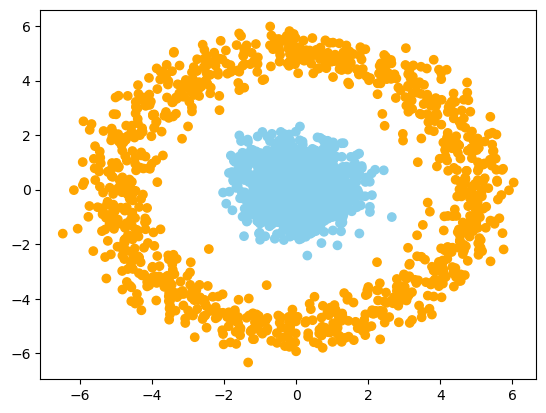

In [ ]:
plt.scatter(dataset[:,0]*5, dataset[:,1]*5, c=['orange' if i==0 else 'skyblue' for i in targets])
plt.show()

케라스를 이용하여 "모델 A"를 구성한 다음에 위 데이터셋을 이용하여 훈련시키고자 한다.
먼저, `targets`의 모양을 다음과 같이 변환시킨다.
이유는 케라스 모델은 타깃 데이터셋도 2차원 텐서를 요구하기 때문이다.

신경망 모델은 데이터 샘플 별로 여러 종류의 값을 동시에 예측할 수 있기에
하나의 샘플에 대한 예측값을 종류별 예측값으로 구성된 벡터로 계산한다.
여기서는 데이터 샘플 별로 양성/음성 여부에 대해서만 예측하기 때문에
한 샘플에 대한 예측값은 길이가 1인 벡터이다.
따라서 타깃셋은 (2000, 1) 모양의 텐서이어야 한다.

In [ ]:
targets = targets.reshape(-1,1)
targets

array([[1],
       [0],
       [1],
       ...,
       [1],
       [1],
       [0]])

모델 A를 신경망 모델 `model_A`로 구성하면 다음과 같다.

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

model_A = keras.Sequential([
    layers.Dense(4, activation="tanh"),   # 첫째 은닉층
    layers.Dense(2, activation="tanh"),   # 둘째 은닉층
    layers.Dense(1, activation="sigmoid") # 출력층
    ])

`model_A` 를 아래 옵션을 이용하여 컴파일한다.

- 옵티마이저: `rmsprop`
- 손실: `binary_crossentropy` (이진 분류 용도의 손실 함수 지정)
- 평가지표: `accuracy` (정확도 평가)

In [ ]:
model_A.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

50대 50의 비율로 훈련용 데이터셋과 타깃셋인 `x_train`, `y_train`과
테스트용 데이터셋과 타깃셋 `x_test`, `y_test`를 지정한다.

In [ ]:
x_train, y_train = dataset[:1000], targets[:1000]
x_test, y_test = dataset[1000:], targets[1000:]

모델을 훈련시킨다.
`fit()` 메서드의 반환값은 훈련이 잘 된 모델의 정보를 담고 있는 `History` 객체이다.

In [ ]:
history = model_A.fit(x_train, y_train, epochs=30, batch_size=10)

Epoch 1/30
100/100 [==============================] - 4s 6ms/step - loss: 0.7052 - accuracy: 0.5340
Epoch 2/30
100/100 [==============================] - 0s 4ms/step - loss: 0.6954 - accuracy: 0.5950
Epoch 3/30
100/100 [==============================] - 0s 4ms/step - loss: 0.6887 - accuracy: 0.6300
Epoch 4/30
100/100 [==============================] - 0s 4ms/step - loss: 0.6836 - accuracy: 0.6630
Epoch 5/30
100/100 [==============================] - 0s 3ms/step - loss: 0.6782 - accuracy: 0.6670
Epoch 6/30
100/100 [==============================] - 0s 4ms/step - loss: 0.6726 - accuracy: 0.6810
Epoch 7/30
100/100 [==============================] - 0s 4ms/step - loss: 0.6664 - accuracy: 0.6840
Epoch 8/30
100/100 [==============================] - 0s 4ms/step - loss: 0.6597 - accuracy: 0.6870
Epoch 9/30
100/100 [==============================] - 0s 3ms/step - loss: 0.6525 - accuracy: 0.6850
Epoch 10/30
100/100 [==============================] - 0s 3ms/step - loss: 0.6450 - accuracy: 0.6880

`History` 객체는 훈련된 모델의 다양한 정보를 저장한다.
예를 들어 `model` 속성은 훈련된 모델을 저장한다.
아래 코드는 훈련된 모델이 `Sequential` 모델임을 확인해준다.

In [ ]:
type(history.model)

keras.src.engine.sequential.Sequential

케라스의 모든 모델은 `keras.Model` 클래스를 상속한다.

In [ ]:
isinstance(history.model, keras.Model)

True

따라서 모델에 사용된 층의 구성을 확인기 위해
`Model` 클래스의 인스턴스 메서드인 `summary()` 메서드를 이용할 수 있다.

In [ ]:
history.model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (10, 4)                   12        
                                                                 
 dense_1 (Dense)             (10, 2)                   10        
                                                                 
 dense_2 (Dense)             (10, 1)                   3         
                                                                 
Total params: 25 (100.00 Byte)
Trainable params: 25 (100.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


위 결과가 설명하는 바는 다음과 같다.

- `Layer (type)` 열: 각 층에 사용된 층의 이름과 종류. 이름을 별도로 지정하지 않으면 자동으로 지정된다.
- `Output Shape` 열: 각 층에서 생성되는 출력 텐서의 모양.
    예를 들어 (10, 4)에서 10은 배치 크기를, 4는 네 개의 유닛 개수. 즉 원래 2개의 특성을 갖는 데이터 샘플 각각을
    4개의 특성을 갖는 데이터 샘플로 변환.
- `Param`: 각 층에서 학습되는 파라미터(가중치와 편향)의 개수. 계산법은 다음과 같음.
    - 첫째 층의 파라미터: `2*4 + 4 = 12`
    - 둘째 층의 파라미터: `4*2 + 2 = 10`
    - 셋째 층의 파라미터: `2*1 + 1 = 3`

기타 요소는 다음과 같다.

- `Toral params`: 파라미터 수의 총합. `12 + 10 + 3 = 25`
- `Trainable params`: 훈련되는 파라미터 수의 총합. `12 + 10 + 3 = 25`
- `Non-trainable params`: 훈련되지 않는 파라미터 수의 총합. `0 + 0 + 0 = 0`.
    즉, 위 모델은 훈련되지 않는 파라미터 사용하지 않음.


`history.model`이 가리키는 모델과 `model_A` 동일한 모델을 가리킨다.
이유는 `model_A.fit()` 메서드가 실행되는 동안 `model_A`가 훈련되는데,
이는 지정된 가중치 행렬과 편향 벡터가 모델 자체에서 업데이트 되는 것을 의미하기 때문이다.

실제로 테스테셋의 처음 5개 데이터 샘플에 대한 예측값이 동일함을 아래 코드로 확인할 수 있다.

In [ ]:
model_A.predict(x_test[:5])

1/1 [==============================] - 0s 90ms/step


array([[0.42474008],
       [0.43255848],
       [0.30604357],
       [0.22624312],
       [0.31857792]], dtype=float32)

In [ ]:
history.model.predict(x_test[:5])

1/1 [==============================] - 0s 21ms/step


array([[0.42474008],
       [0.43255848],
       [0.30604357],
       [0.22624312],
       [0.31857792]], dtype=float32)

`History` 객체의 `params` 인스턴스 속성은 `fit()` 메서드가 모델 훈련에 사용되는
하이퍼파라미터를 저장한다.
아래 코드는 30번의 에포크와 스텝의 수를 보여준다.
참고로 스텝은 훈련셋의 크기와 배치크기에 의해 자동 결정된다.
여기서 100인 이유는 훈련셋의 크기가 1000이고 배치 크기가 10 기에
총 `1000/10 = 100` 번의 스텝이 한 번의 에포크 동안 실행된다.
`verbose`는 모델 훈련 과정중에 에포크별로 진행상황과 평가 결과를 어떻게 보여줄 것인가를 지정한다.
별 이유가 없다면 기본값을 굳이 바꿀 필요는 없다.

In [ ]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 100}

`History` 객체의 `history` 속성은 훈련 과정에서 에포크 단위로 계산된
훈련셋과 검증셋에 대한 손실값(loss)과 평가지표를 저장한 사전 객체를 가리킨다.
여기서는 검증셋은 지정되지 않았고, 평가지표로 정확도(accuracy) 하나만 사용하였기에
훈련셋에 대한 손실값(loss)과 정확도(accuracy)만 에포크 단위로 저장한다.

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy'])

예를 들어 에포크 별 훈련셋에 대한 손실값의 변화는 다음과 같다.

In [ ]:
history.history['loss']

[0.7051876187324524,
 0.6953816413879395,
 0.6887145042419434,
 0.6835972666740417,
 0.6782219409942627,
 0.6726423501968384,
 0.6664418578147888,
 0.6596653461456299,
 0.6525229215621948,
 0.6449557542800903,
 0.6368668079376221,
 0.6285926103591919,
 0.6199349761009216,
 0.6107009053230286,
 0.6004608869552612,
 0.5890800952911377,
 0.5757837295532227,
 0.5594943761825562,
 0.5417194962501526,
 0.522828221321106,
 0.5028665661811829,
 0.48066896200180054,
 0.45762521028518677,
 0.4346924126148224,
 0.4105972349643707,
 0.3860207200050354,
 0.3626480996608734,
 0.3405416011810303,
 0.319349080324173,
 0.2991827130317688]

에포크 별 훈련셋에 대한 정확도의 변화는 다음과 같다.

In [ ]:
history.history['accuracy']

[0.5339999794960022,
 0.5950000286102295,
 0.6299999952316284,
 0.6629999876022339,
 0.6669999957084656,
 0.6809999942779541,
 0.6840000152587891,
 0.6869999766349792,
 0.6850000023841858,
 0.6880000233650208,
 0.6899999976158142,
 0.6909999847412109,
 0.6909999847412109,
 0.6949999928474426,
 0.6980000138282776,
 0.7020000219345093,
 0.7049999833106995,
 0.7139999866485596,
 0.7170000076293945,
 0.7279999852180481,
 0.7379999756813049,
 0.7730000019073486,
 0.8450000286102295,
 0.8849999904632568,
 0.9210000038146973,
 0.9390000104904175,
 0.9549999833106995,
 0.9660000205039978,
 0.9829999804496765,
 0.9959999918937683]

In [ ]:
print(1e-5 * 100000)

1.0


**문제 1**

모델 B를 신경망 모델 `model_B`로 구성한 다음 훈련시킨 결과를 설명하라.

견본 답안:

아래 모델을 이용한다.

In [ ]:
model_B = keras.Sequential([
    layers.Dense(4, activation="tanh"),   # 첫째 은닉층 -1 ~ 1
    layers.Dense(1, activation="sigmoid") # 출력층 0 ~ 1
    ])

**문제 2**

모델 C를 신경망 모델 `model_C`로 구성한 다음 훈련시킨 결과를 설명하라.

견본 답안:

아래 모델을 이용한다.

In [ ]:
model_C = keras.Sequential([
    layers.Dense(4, activation="tanh"),   # 1번 은닉층 4개의 유닛
    layers.Dense(3, activation="tanh"),   # 2번 은닉층 3개의 유닛
    layers.Dense(2, activation="tanh"),   # 3번 은닉층 2개의 유닛
    layers.Dense(1, activation="sigmoid") # 출력층
    ])

**문제 3**

`model_A`, `model_B`, `model_C`의 성능을 비교하라.

견본 답안:

배치 크기 변화 등을 활용하여 성능을 비교한다.

**문제 4**

아래 설정을 변경하면서 최고 성능의 모델을 구현하라.

- 층과 유닛의 개수
- 훈련셋과 테스트셋의 비율
- 학습률
- 규제와 규제율
- 활성화 함수
- 배치 크기
- 에포크

견본 답안: 설정에 따라 설정값을 변경하는 방식이 다르다.

- 층과 유닛 수: 모델 지정할 때. 이전 문제에서 많이 사용했음.

- 훈련셋과 테스텟의 비율: 앞서 코드 설명할 때 이미 사용했음. 또는 사이킷런 API를 다음과 같이 사용 가능.
    예를 들어 아래 코드는 8대 2의 비율로 훈련셋과 테스트셋을 지정한다.

    ```python
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(dataset, targets, test_size=0.2, random_state=42)
    ```

- 학습률 지정: 경사하강법을 적용할 때 사용되는 설정이기에 옵티마이저를 지정할 때 함께 설정한다.
    예를 들어 아캐 코드는 `Adam` 옵티마이저와 함께 학습률을 0.001로 지정한다.
    
    ```python
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    ```

- 규제와 규제율: 규제는 층별로 가중치와 편향의 절대값이
    너무 커지지 않도록 유도하며, L1 과 L2 규제 또는 L1L2 혼합 규제 세 종류로 나뉜다.
    보다 자세한 내용은 [릿지규제(L2 규제), 라쏘 규제(L1 규제), 엘라스틱 넷(L1, L2 혼합 규제)](https://codingalzi.github.io/handson-ml3/training_models.html)를 참고한다.
    
    예를 들어, 아래 코드는 L1과 L2 규제를 함께 적용하는 방식을 보여준다.
    자세한 설명은 [층별 가중치 규제](https://keras.io/api/layers/regularizers/)를 참고한다.
    
    ```python
    from tensorflow.keras import layers
    from tensorflow.keras import regularizers

    layer = layers.Dense(
        units=64,
        kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
        bias_regularizer=regularizers.L2(1e-4),
        activity_regularizer=regularizers.L2(1e-5)
    ```

- 활성화 함수: relu, prelu, tanh 등 다양한 활성화 함수를 층을 지정할 때 함께 지정한다.

- 배치 크기와 에포크: 적당하게 지정. `fit()` 메서드에서 지정.

In [ ]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras import regularizers

# 데이터 전처리
X_train, X_test, y_train, y_test = train_test_split(dataset, targets, test_size=0.2, random_state=42)

# 모델 생성
layer1 = Dense(4,
               kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
               bias_regularizer=regularizers.L2(1e-4),
               activity_regularizer=regularizers.L2(1e-5),
               activation='relu')
layer2 = Dense(2,
               kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
               bias_regularizer=regularizers.L2(1e-4),
               activity_regularizer=regularizers.L2(1e-5),
               activation='relu')
layer3 = Dense(1, activation='sigmoid')

model = Sequential([layer1, layer2, layer3])

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.001),
              loss="binary_crossentropy",
              metrics=["accuracy"])

# 모델 훈련
model.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_test, y_test))

# 모델 평가
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

Epoch 1/30
25/25 [==============================] - 2s 17ms/step - loss: 0.6622 - accuracy: 0.5031 - val_loss: 0.6584 - val_accuracy: 0.5650
Epoch 2/30
25/25 [==============================] - 0s 9ms/step - loss: 0.6572 - accuracy: 0.5587 - val_loss: 0.6532 - val_accuracy: 0.5975
Epoch 3/30
25/25 [==============================] - 0s 8ms/step - loss: 0.6518 - accuracy: 0.5831 - val_loss: 0.6473 - val_accuracy: 0.6325
Epoch 4/30
25/25 [==============================] - 0s 9ms/step - loss: 0.6460 - accuracy: 0.6069 - val_loss: 0.6410 - val_accuracy: 0.6550
Epoch 5/30
25/25 [==============================] - 0s 9ms/step - loss: 0.6398 - accuracy: 0.6263 - val_loss: 0.6344 - val_accuracy: 0.6850
Epoch 6/30
25/25 [==============================] - 0s 8ms/step - loss: 0.6332 - accuracy: 0.6612 - val_loss: 0.6274 - val_accuracy: 0.7250
Epoch 7/30
25/25 [==============================] - 0s 9ms/step - loss: 0.6262 - accuracy: 0.6769 - val_loss: 0.6197 - val_accuracy: 0.7350
Epoch 8/30
25/25 [=

## 캘리포니아 주택가격 데이터셋

**문제 1**

캘리포니아 주택가격 데이터셋을 이용한 회귀 심층 신경망 모델을 구성하고 훈련시켜라.
단, `Sequential` 모델과 `Dense` 층 이외에 다른 종류의 모델과 층은 절대로 이용하지 않는다.
또한 캘리포니아 데이터셋과 모델 구성에 대해서는 인터넷 자료를 참고하며,
모델을 구성할 때 다음 사항에 주의한다.

- 회귀 모델의 마지막 출력층은 활성화 함수를 사용하지 않는다.
- 모델 컴파일 요소(옵티마이저, 손실 함수, 평가지표) 또한 인터넷 자료를 참고한다.
- 은닉층의 활성화 함수는 `relu` 함수를 이용한다.


힌트: 아래 사이트를 참고한다.

- https://www.kaggle.com/code/saurav9786/ann-with-tensorflow-2-0-to-predict-housing-prices

**견본 답안**

pandas와 numpy 라이브러리가 필요하다.

In [ ]:
import numpy as np
import pandas as pd

**데이터셋 다운로드**

캘리포니아 주택가격 데이터셋은 텐서플로우가 제공하지 않는다.
여기서는 아래 사이트에 저장되어 있는 csv 파일을 이용한다.

- https://raw.githubusercontent.com/codingalzi/dlp2/master/jupyter-book/data/housing.csv

`pd.read_csv()` 함수로 csv 파일에 저장된 데이터셋을 데이터프레임으로 불러온다.

In [ ]:
housing_df = pd.read_csv("https://raw.githubusercontent.com/codingalzi/dlp2/master/jupyter-book/data/housing.csv")

각 데이터 샘플은 10개의 특성을 가지며 총 20,640개의 데이터샘플이 포함된다.

In [ ]:
housing_df.shape

(20640, 10)

10개의 특성은 다음과 같다.

In [ ]:
housing_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


**데이터 전처리: 결측치 처리**

일부 특성에 결측치가 있는지 확인한다.

In [ ]:
housing_df.isna().any()

longitude             False
latitude              False
housing_median_age    False
total_rooms           False
total_bedrooms         True
population            False
households            False
median_income         False
median_house_value    False
ocean_proximity       False
dtype: bool

`total_bedrooms`(구역별 총 방 개수) 속성에 결측치가 207개 있다.

In [ ]:
housing_df.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

결측치를 포함한 샘플은 모두 삭제한다.
케라스 모델은 일반적으로 결측치가 포함된 데이터를 처리하지 못한다.

In [ ]:
housing_df.dropna(inplace=True)

이제 어떠한 결측치도 포함되지 않음을 확인할 수 있다.

In [ ]:
housing_df.isna().any()

longitude             False
latitude              False
housing_median_age    False
total_rooms           False
total_bedrooms        False
population            False
households            False
median_income         False
median_house_value    False
ocean_proximity       False
dtype: bool

데이터셋의 크기가 20,433으로 조금 작아졌다.

In [ ]:
housing_df.shape

(20433, 10)

[링크 텍스트](https://)**데이터 전처리: 원-핫 인코딩**

`ocean_proximity`(해안근접도) 특성이 문자열로 되어 있다.

In [ ]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20433 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20433 non-null  float64
 1   latitude            20433 non-null  float64
 2   housing_median_age  20433 non-null  float64
 3   total_rooms         20433 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20433 non-null  float64
 6   households          20433 non-null  float64
 7   median_income       20433 non-null  float64
 8   median_house_value  20433 non-null  float64
 9   ocean_proximity     20433 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.7+ MB


In [ ]:
housing_df['ocean_proximity']

0        NEAR BAY
1        NEAR BAY
2        NEAR BAY
3        NEAR BAY
4        NEAR BAY
           ...   
20635      INLAND
20636      INLAND
20637      INLAND
20638      INLAND
20639      INLAND
Name: ocean_proximity, Length: 20433, dtype: object

해안근접도는 다섯 종류로 구분된다.

In [ ]:
housing_df['ocean_proximity'].unique()

array(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'],
      dtype=object)

텐서플로우 모델에 적절하지 않기에 원-핫 인코딩한다.
즉, 해안근접도 특성을 없애고 대신 5개의 특성을 새로 추가한다.
추가되는 특성의 값은 해안근접도를 원-핫 인코딩 특성이다.
이를 위해 `pd.get_dummies()` 함수를 이용한다.

In [ ]:
housing_df_dummy = pd.get_dummies(data = housing_df,
                                  columns = ['ocean_proximity'] ,
                                  prefix = ['ocean_proximity'] ,
                                  dtype='float64')

`ocean_proximity` 특성 대신에 새로운 특성 다섯 개가 추가되었다.
추가된 특성의 `dtype`은 `float64`이다.

In [ ]:
housing_df_dummy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20433 entries, 0 to 20639
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   longitude                   20433 non-null  float64
 1   latitude                    20433 non-null  float64
 2   housing_median_age          20433 non-null  float64
 3   total_rooms                 20433 non-null  float64
 4   total_bedrooms              20433 non-null  float64
 5   population                  20433 non-null  float64
 6   households                  20433 non-null  float64
 7   median_income               20433 non-null  float64
 8   median_house_value          20433 non-null  float64
 9   ocean_proximity_<1H OCEAN   20433 non-null  float64
 10  ocean_proximity_INLAND      20433 non-null  float64
 11  ocean_proximity_ISLAND      20433 non-null  float64
 12  ocean_proximity_NEAR BAY    20433 non-null  float64
 13  ocean_proximity_NEAR OCEAN  20433 no

In [ ]:
housing_df_dummy.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,0.0,0.0,0.0,1.0,0.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,0.0,0.0,0.0,1.0,0.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,0.0,0.0,0.0,1.0,0.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,0.0,0.0,0.0,1.0,0.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,0.0,0.0,0.0,1.0,0.0


**훈련 데이터셋 준비**

지도학습 모델 훈련을 위해 입력 데이터셋과 타깃 데이터셋을 지정한다.
타깃은 중앙 주택가격(`median_house_value`)으로 정하고 나머지 특성을 입력값의 특성으로 사용한다.

In [ ]:
# 입력 데이터셋
X = housing_df_dummy.drop("median_house_value", axis=1)

# 타깃 데이터셋: 2차원으로 지정
y = housing_df_dummy[["median_house_value"]]

입력 데이터셋: 중앙 주택가격을 제외한 13개의 특성으로 구성됨

In [ ]:
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,0.0,0.0,0.0,1.0,0.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,0.0,0.0,0.0,1.0,0.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,0.0,0.0,0.0,1.0,0.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,0.0,0.0,0.0,1.0,0.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,0.0,0.0,0.0,1.0,0.0


타깃 데이터셋: 중앙 주택가격으로 구성됨

In [ ]:
y.head()

,median_house_value
0,452600.0
1,358500.0
2,352100.0
3,341300.0
4,342200.0


**훈련용과 테스트용 데이터셋 구분**

7 대 3의 비율로 데이터셋을 훈련용 데이터셋과 테스트용데이터셋으로 구분한다.
이를 위해 사이킷런의 `train_test_split()` 함수를 이용한다.

주의사항: 입력 데이터셋과 타깃 데이터셋을 함께 동기화하면서 구분한다.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

훈련용 데이터셋 크기

In [ ]:
X_train.shape

(14303, 13)

In [ ]:
y_train.shape

(14303, 1)

테스트용 데이터셋 크기

In [ ]:
X_test.shape

(6130, 13)

In [ ]:
y_test.shape

(6130, 1)

**입력 데이터셋 표준화**

보다 효율적인 훈련을 위해 입력 데이터셋을 표준화 한다.
사이킷런의 `StandardScaler` 변환기를 이용하여 쉽게 처리할 수 있다.

먼저 훈련용 입력 데이터셋을 변환시킨다.
이때 `fit_transform()` 메서드를 이용하면 입력 데이터셋의 특성별 평균값과 표준편차를 계산하여
표준화를 진행한다.

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

테스트용 입력 데이터셋의 표준화는 단순히 `transform()` 메서드를 이용한다.
이유는 테스트셋에 대한 정보를 전혀 사용하지 않기 위해
표준화를 진행해야 하기 때문이다.

In [ ]:
X_test = scaler.transform(X_test)

주의사항: 타깃 데이터셋은 표준화하지 않는다.

**검증용 데이터셋 지정**

훈련 중에 모델의 일반화 성능을 평가하기 위해 훈련용 데이터셋의 10%를 검증용 데이터셋으로 지정한다.

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.3)

**케라스 활용 모델 구성**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

모델 지정

In [ ]:
model = Sequential()

# 은닉층 3개
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))

# 출력층: 회귀 모델. 유닛 1개. 활성화 함수 없음.
model.add(Dense(1))

모델 컴파일

- 옵티마이저: `adam`
- 손실 함수: 평균 제곱오차(`mse`)
- 평가지표: 평균 제곱근오차(`tf.keras.metrics.RootMeanSquaredError`)와 평균절대오차(`mae`)

In [ ]:
model.compile(optimizer='adam',
              loss='mse',
              metrics=[tf.keras.metrics.RootMeanSquaredError(),'mae'])

**모델 훈련**

- 배치 크기(`batch_size`): 256
- 에포크(`epoch`): 30
- 검증 데이터셋 지정

In [ ]:
history = model.fit(X_train,
                    y_train,
                    batch_size = 256,
                    epochs = 30,
                    validation_data=(X_val, y_val))

Epoch 1/30
40/40 [==============================] - 2s 15ms/step - loss: 55946465280.0000 - root_mean_squared_error: 236530.0469 - mae: 206524.4688 - val_loss: 56523575296.0000 - val_root_mean_squared_error: 237746.8750 - val_mae: 208052.3281
Epoch 2/30
40/40 [==============================] - 0s 9ms/step - loss: 55942823936.0000 - root_mean_squared_error: 236522.3438 - mae: 206516.7188 - val_loss: 56515330048.0000 - val_root_mean_squared_error: 237729.5312 - val_mae: 208034.7031
Epoch 3/30
40/40 [==============================] - 0s 8ms/step - loss: 55924068352.0000 - root_mean_squared_error: 236482.7031 - mae: 206476.9844 - val_loss: 56478486528.0000 - val_root_mean_squared_error: 237652.0312 - val_mae: 207957.0156
Epoch 4/30
40/40 [==============================] - 0s 9ms/step - loss: 55855415296.0000 - root_mean_squared_error: 236337.5000 - mae: 206333.4062 - val_loss: 56362270720.0000 - val_root_mean_squared_error: 237407.3906 - val_mae: 207714.0625
Epoch 5/30
40/40 [=============

`History` 객체에 저장된 내용은 훈련용과 검증용 데이터셋에 대한
손실값, 평균제곱근오차, 평균절대오차이다.

In [ ]:
history.history.keys()

dict_keys(['loss', 'root_mean_squared_error', 'mae', 'val_loss', 'val_root_mean_squared_error', 'val_mae'])

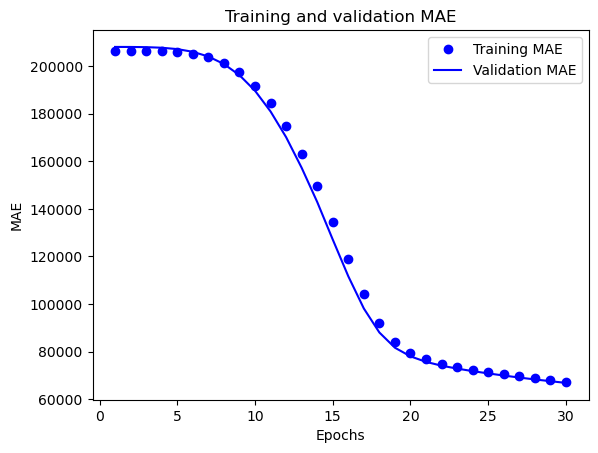

In [ ]:
import matplotlib.pyplot as plt

mae = history.history["mae"]
val_mae = history.history["val_mae"]
epochs = range(1, len(mae) + 1)

plt.plot(epochs, mae, "bo", label="Training MAE")
plt.plot(epochs, val_mae, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

위 그래프를 보면 훈련 데이터셋 뿐만 아니라 검증 데이터셋에 대한 성능이 계속해서 좋아지고 있다.
이는 아직 훈련이 완성되지 않았음을 의미한다.
따라서 에포크를 더 크게 지정해서 훈련을 더 시킬 수 있다.

**모델 평가**

테스트셋을 이용하여 모델을 평가한다.

In [ ]:
model.evaluate(X_test, y_test)

192/192 [==============================] - 1s 4ms/step - loss: 7810512384.0000 - root_mean_squared_error: 88377.1016 - mae: 65992.7188


[7810512384.0, 88377.1015625, 65992.71875]

**추가 문제**

1. 에포크를 얼마나 더 크게 해야 과대적합이 발생하는지 확인하라.
1. 모델의 구성을 변경하여 보다 좋은 성능의 모델을 구현하라.